In [1]:
import numpy as np
import math
import scipy.special
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

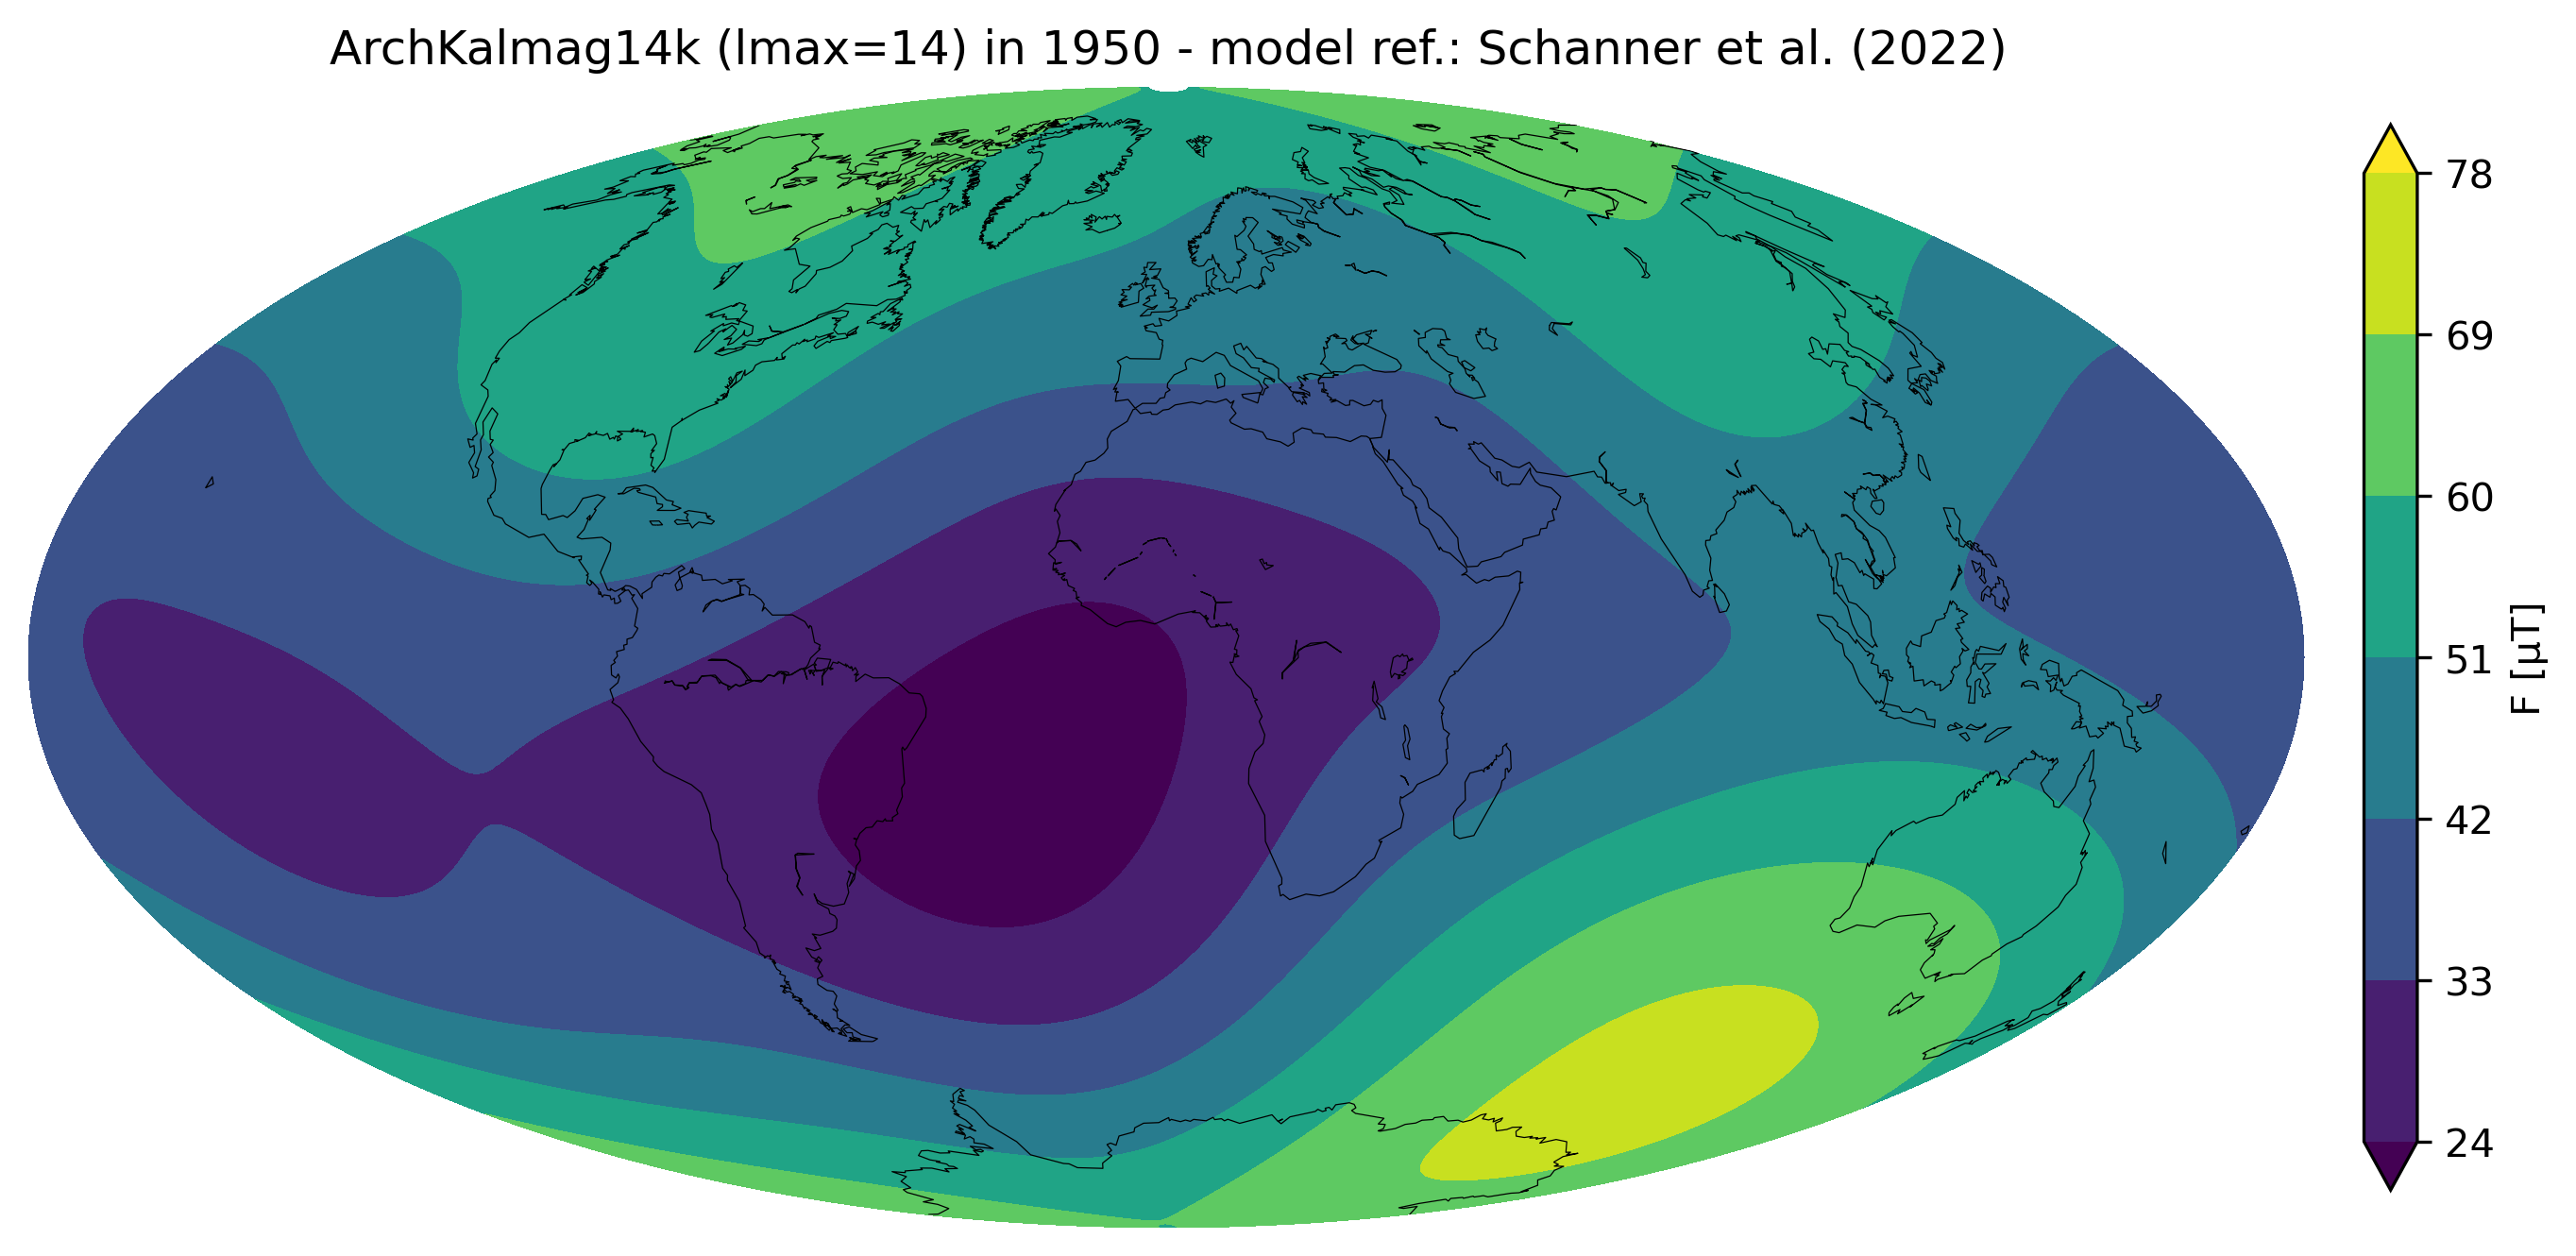

In [2]:
filepath = r"...\ArchKalmag14k_lmax14.txt"  # replace ... with the path where the covobsx2.txt file is stored in you pc 
target_year = 1950     # chose a time between -12000 and 1950 (time coverage of this model)
lmax = 14              # chose a lmax between 1 and 14 (you can go up to lmax=20 with this model, but you have to download the proper file - see README)
a = r = 6371.2         # radius of our beautiful planet

# function for reading the Gauss coefficients as they are organized in the original file dowloaded in the official website (see README)
def read_gauss_coeffs_archkalmag(filename, target_year, lmax=14):
    with open(filename, "r") as f:
        lines = f.readlines()

    years = list(map(float, lines[0].strip().split()))
    if float(target_year) not in years:
        raise ValueError(f"Year {target_year} no found in the file.")
    idx = years.index(float(target_year))

    coeff_lines = lines[1:]
    coeffs = [list(map(float, line.strip().split())) for line in coeff_lines]
    coeffs_at_year = [row[idx] for row in coeffs]

    gsh, hsh = [], []
    i = 0
    for l in range(1, lmax + 1):
        for m in range(0, l + 1):
            gsh.append(coeffs_at_year[i]); i += 1
            if m == 0:
                hsh.append(0.0)
            else:
                hsh.append(coeffs_at_year[i]); i += 1

    return np.array(gsh, dtype=float), np.array(hsh, dtype=float)

def idx_lm(l, m):
    return sum((L + 1) for L in range(1, l)) + m

# Function initially created by Filipe Terra-Nova (GitHub: @filipecros) and modified by Victor Marum
def magnetic_field(gsh, hsh, lmax, r_km, lats_deg, lons_deg):
    lons2d, lats2d = np.meshgrid(lons_deg, lats_deg)
    phi_rad = np.radians(lons2d)              # longitude
    theta_rad = np.radians(90.0 - lats2d)     # colatitude
    cos_t = np.cos(theta_rad)
    sin_t = np.sin(theta_rad)

    B_r = np.zeros_like(cos_t, dtype=float)      # radial component of B
    B_phi = np.zeros_like(cos_t, dtype=float)    # longitudinal component of B
    B_theta = np.zeros_like(cos_t, dtype=float)  # colatitudinal component of B

    i = 0
    for l in range(1, lmax + 1):
        factor = (a / r_km) ** (l + 2)
        for m in range(0, l + 1):
            g = gsh[i]
            h = hsh[i]

            schmidt = 1.0 if m == 0 else ((-1.0) ** m) * np.sqrt(
                2.0 * math.factorial(l - m) / math.factorial(l + m)
            )

            Pnm = scipy.special.lpmv(m, l, cos_t)
            Pnm_prev = scipy.special.lpmv(m, l - 1, cos_t) if l > 0 else 0.0
            div_Pnm = (l * cos_t * Pnm - (l + m) * Pnm_prev) / np.sqrt(np.maximum(1.0 - cos_t**2, 1e-30))

            cos_mphi = np.cos(m * phi_rad)
            sin_mphi = np.sin(m * phi_rad)

            common = (g * cos_mphi + h * sin_mphi)

            B_r     += schmidt * (l + 1) * factor * Pnm * common
            B_theta += schmidt * factor * div_Pnm * common

            if m != 0:
                B_phi += schmidt * m * factor / np.maximum(sin_t, 1e-30) * Pnm * (-g * sin_mphi + h * cos_mphi)

            i += 1

    return B_r, B_phi, B_theta, lons2d, lats2d

# creating the grid of the map
lons = np.arange(-180, 180, 1)
lats = np.arange(-90, 90, 1)

gsh, hsh = read_gauss_coeffs_archkalmag(filepath, target_year, lmax=lmax)

B_r, B_phi, B_theta, lon2d, lat2d = magnetic_field(gsh, hsh, lmax, r, lats, lons)

F_uT = np.sqrt(B_r**2 + B_theta**2 + B_phi**2) / 1000.0  # calculating F in microT

fig = plt.figure(figsize=(10, 5), dpi=300)
ax = fig.add_subplot(111)

m = Basemap(projection="hammer", lon_0=0, ax=ax)
x, y = m(lon2d, lat2d)

levels = np.arange(24, 78 + 9, 9)

cs = ax.contourf(x, y, F_uT, levels=levels, cmap="viridis", extend="both")
m.drawmapboundary(color="none")
m.drawcoastlines(color="black", linewidth=0.3)

cbar = plt.colorbar(cs, ax=ax, orientation="vertical", pad=0.02, shrink=0.8, ticks=levels)
cbar.set_label("F [μT]")

ax.set_title(f"ArchKalmag14k (lmax={lmax}) in {target_year} - model ref.: Schanner et al. (2022)")
plt.tight_layout()
plt.show()